# ** **Sentiment Analysis of Indian Politics Tweets Using Logistic Regression and Data Visualization Techniques** -**
Performed sentiment analysis on Indian political tweets using Logistic Regression and TfidfVectorizer.

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
import warnings
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Load and Preprocess Data

In [2]:
# Load the Dataset
df = pd.read_csv('/content/Twitter_Data.csv')

# Minimal stopwords list for this environment
minimal_stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_tweet(tweet):
    if isinstance(tweet, str):
        tweet = tweet.lower()
        tweet = re.sub("[^a-zA-Z#]", " ", tweet)
        tweet = ' '.join([stemmer.stem(word) for word in tweet.split() if word not in minimal_stop_words])
    else:
        tweet = ""
    return tweet

# Ensure 'tweet' column exists and preprocess it
df['tweet'] = df['tweet'].astype(str)
df['clean_text'] = df['tweet'].apply(preprocess_tweet)

# Drop rows with missing 'category'
df.dropna(subset=['category'], inplace=True)
df['sentiment'] = df['category'].map({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})

# Display the first few rows of the preprocessed data
print(df.head())

                                               tweet  category  \
0  when modi promised “minimum government maximum...      -1.0   
1  talk all the nonsense and continue all the dra...       0.0   
2  what did just say vote for modi  welcome bjp t...       1.0   
3  asking his supporters prefix chowkidar their n...       1.0   
4  answer who among these the most powerful world...       1.0   

                                          clean_text sentiment  
0  modi promis minimum govern maximum govern expe...  Negative  
1               talk nonsens continu drama vote modi   Neutral  
2  say vote modi welcom bjp told rahul main campa...  Positive  
3  ask support prefix chowkidar name modi great s...  Positive  
4  answer among power world leader today trump pu...  Positive  


Data Visualization

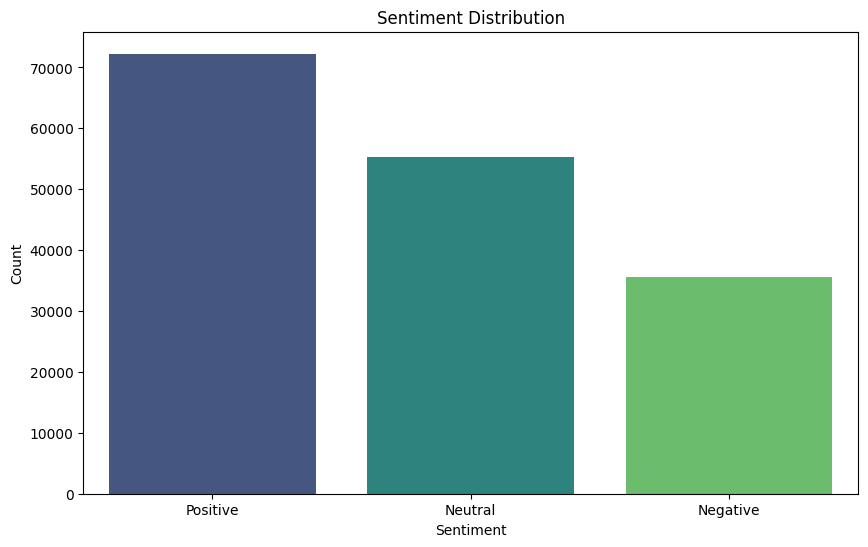

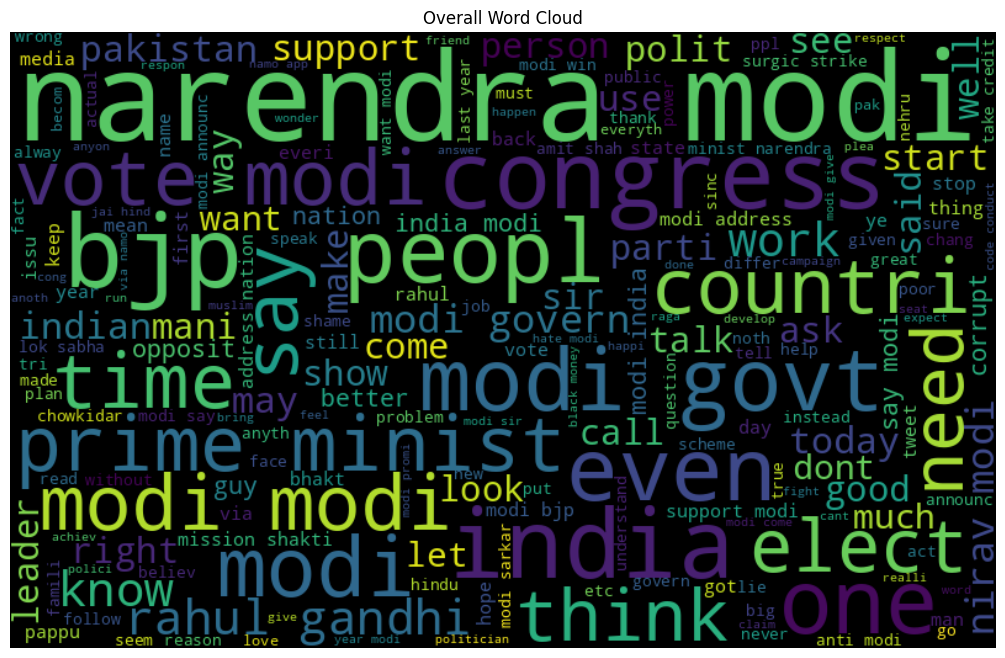

In [3]:
# Bar Plot
plt.figure(figsize=(10, 6))
sentiment_counts = df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word Cloud Visualization
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(text)
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(" ".join(df['clean_text']), 'Overall Word Cloud')

Model Training and Hyperparameter Tuning

In [4]:
# Feature Extraction and Model Training using GridSearchCV
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', LogisticRegression(solver='liblinear'))
])

param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__max_df': [0.75, 1.0],
    'vectorizer__min_df': [1, 2],
    'classifier__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(df['clean_text'], df['category'])

print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'classifier__C': 10, 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}


Model Evaluation

In [5]:
# Model Evaluation
best_model = grid_search.best_estimator_
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], df['category'], random_state=42, test_size=0.25)
best_model.fit(x_train, y_train)
pred = best_model.predict(x_test)

print("F1 Score:", f1_score(y_test, pred, average='weighted'))
print("Accuracy Score:", accuracy_score(y_test, pred))

F1 Score: 0.8198439995190034
Accuracy Score: 0.8204152758688396


Predict Sentiment for User Input

In [6]:
# Function to preprocess user input tweet
def preprocess_user_input(tweet):
    tweet = tweet.lower()
    tweet = re.sub("[^a-zA-Z#]", " ", tweet)
    tweet = " ".join([stemmer.stem(word) for word in tweet.split() if word not in minimal_stop_words])
    return tweet

# Example usage:
user_tweet = input("Enter your tweet: ")
clean_user_tweet = preprocess_user_input(user_tweet)

# Transform the user input using the TfidfVectorizer
user_tweet_tfidf = best_model.named_steps['vectorizer'].transform([clean_user_tweet])

# Predict using the trained Logistic Regression model
prediction = best_model.named_steps['classifier'].predict(user_tweet_tfidf)

# Map prediction to sentiment label
sentiment_label = {1: 'Positive', 0: 'Neutral', -1: 'Negative'}
predicted_sentiment = sentiment_label[prediction[0]]
print("Predicted Sentiment:", predicted_sentiment)

Enter your tweet: Modi is a good orator.
Predicted Sentiment: Positive


Generate Word Cloud for Sentiments

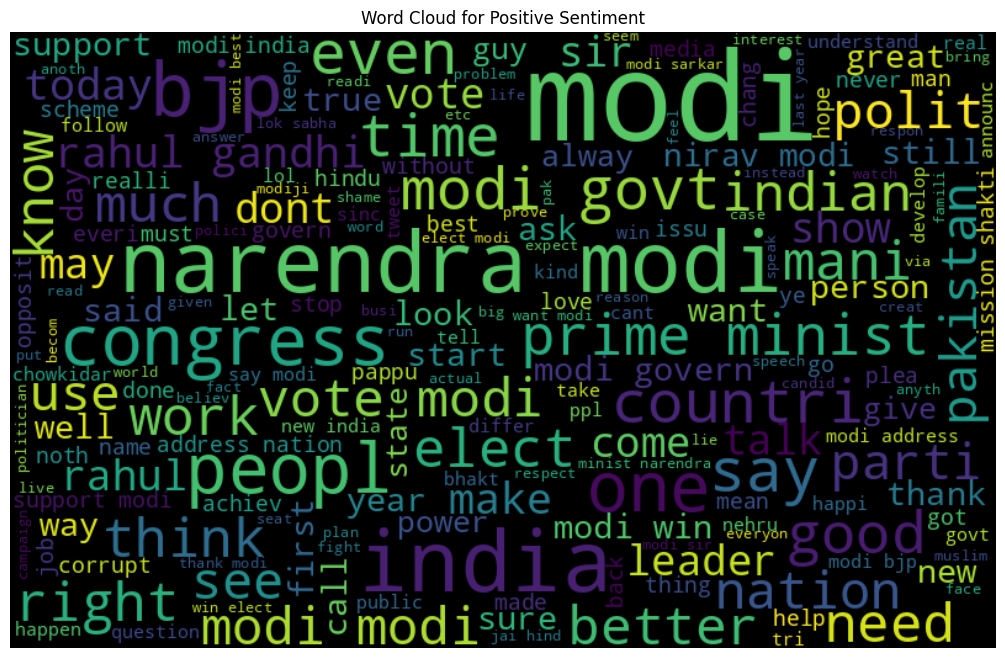

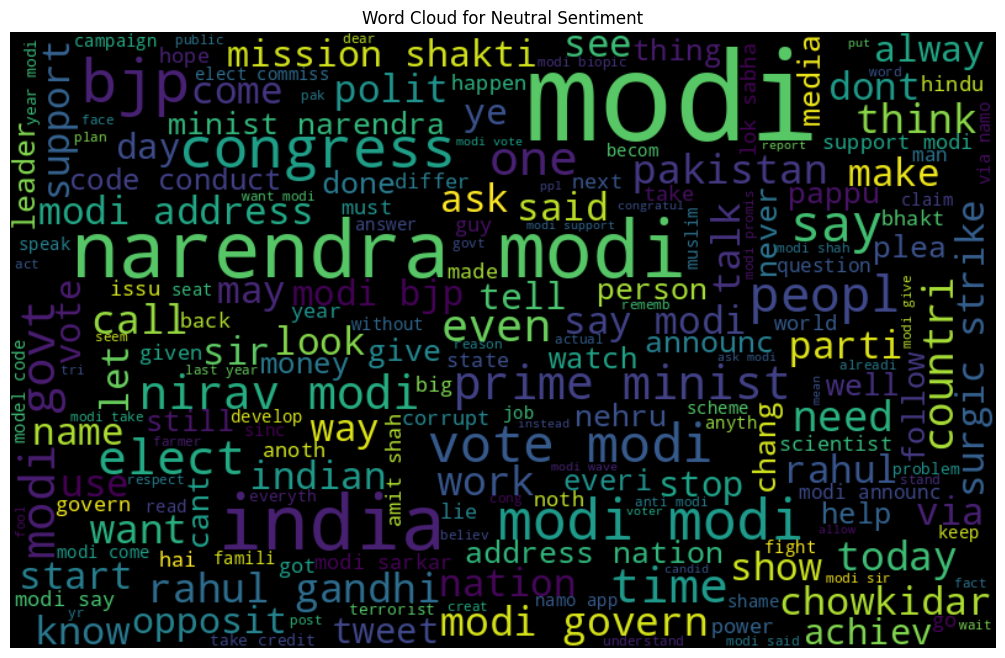

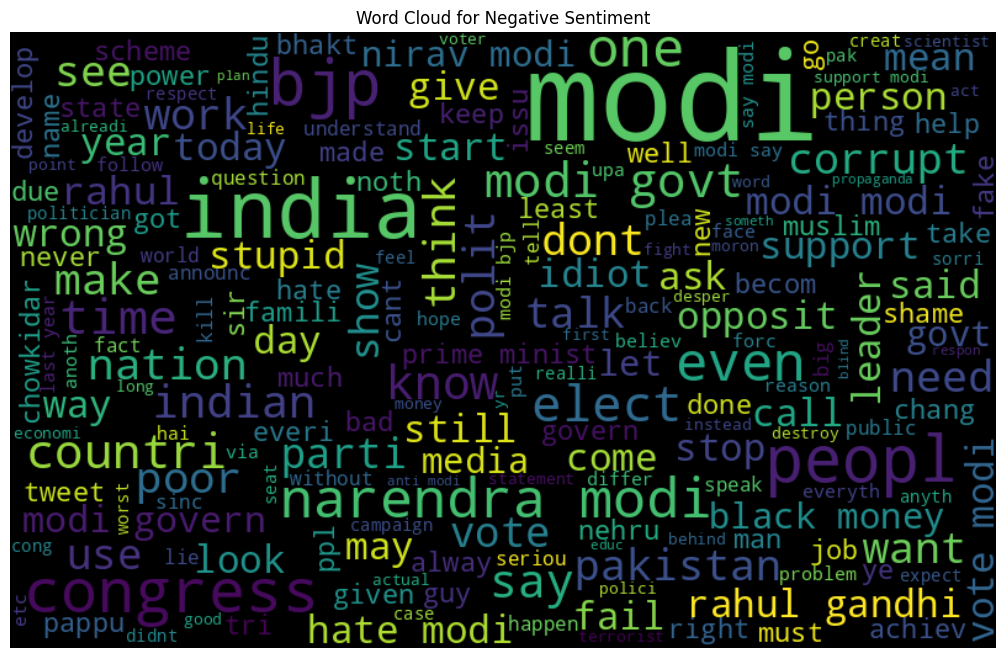

In [7]:
# Word Cloud for Sentiments
generate_wordcloud(" ".join(df[df['category'] == 1]['clean_text']), 'Word Cloud for Positive Sentiment')
generate_wordcloud(" ".join(df[df['category'] == 0]['clean_text']), 'Word Cloud for Neutral Sentiment')
generate_wordcloud(" ".join(df[df['category'] == -1]['clean_text']), 'Word Cloud for Negative Sentiment')